<a href="https://colab.research.google.com/github/linhoangce/pytorch_crash_course/blob/main/transfer_learning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision

torch.__version__, torchvision.__version__

('2.6.0+cu124', '0.21.0+cu124')

In [ ]:
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# Check for torchinfo package
try:
  from torchinfo import summary
except:
  print('[INFO] torchinfo not found. Installing package...')
  !pip install -q torchinfo
  from torchinfo import summary

## Rewrite modular codes for practice

In [ ]:
import os

if not os.path.exists('module_4'):
  os.makedirs('module_4')

In [ ]:
!touch module_4/__init__.py

### Create Datasets and DataLoaders

In [ ]:
%%writefile module_4/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(train_dir: str,
                       test_dir: str,
                       transform: transforms.Compose,
                       batch_size: int,
                       num_workers: int=NUM_WORKERS):
  """
  Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns them into PyTorch Datasets, and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoaders.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.

  Example usage:
    train_dataloader, test_dataloader, class_names = create_dataloaders(
      train_dir=path/to/train_dir,
      test_dir=path/to/test_dir,
      transform=some_transform,
      batch_size=32,
      num_workers=4
    )
  """
  # Use ImageFolder to create datasets
  train_data = datasets.ImageFolder(root=train_dir,
                                    transform=transform)
  test_data = datasets.ImageFolder(root=test_dir,
                                   transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn into dataloaders
  train_dataloader = DataLoader(dataset=train_data,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=num_workers,
                                pin_memory=True)
  test_dataloader = DataLoader(dataset=test_data,
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers=num_workers,
                               pin_memory=True)

  return train_dataloader, test_dataloader, class_names

Overwriting module_4/data_setup.py


### Create script for model builder


In [ ]:
%%writefile module_4/model_builder.py
"""
Contains PyTorch model code to instantiate a TinyVGG model.
"""

import torch
from torch import nn

class TinyVGG(nn.Module):
  """
  Creates the TinyVGG architecture.

  Replicates the TinyVGG architecture from the CNN Explainer website in PyTorch.

  Args:
    input_shape: An integer indicating the number of input channels.
    hidden_units: An integer indicating the number of hidden units between layers.
    output_shape: An integer indicating the number of output units.

  """
  def __init__(self,
               input_shape,
               hidden_units,
               output_shape):
    super().__init__
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block2(self.conv_block1(x)))

Overwriting module_4/model_builder.py


### Training function

In [ ]:
%%writefile module_4/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""

import torch

from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """
  Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then runs through all of the required training steps (forward pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    data_loader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize loss.
    device: A target device to compute on.

  Returns:
     A tuple of training loss and training accuracy metrics.
     In the form (train_loss, train_accuracy).

  """
  # Move model to target device
  model.to(device)

  # Put model in train mode
  model.train()

  # setup train loss and accuracy
  train_loss, train_acc = 0, 0

  # Loop through dataloader in batches
  for batch, (X, y) in enumerate(data_loader):
    # move data to target device
    X, y = X.to(device), y.to(device)

    # forward pass
    logits = model(X)
    y_pred = torch.argmax(logits, dim=1)

    # Calculate loss
    loss = loss_fn(logits, y)

    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()

    # Accumulate loss and acc
    train_loss += loss.item()
    train_acc += (y_pred==y).sum().item() / len(y_pred)

  # Calculate average loss and acc per batch
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """
  Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on.

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy).

  """
  # move model to target device
  model.to(device)

  # setup loss and acc
  test_loss, test_acc = 0, 0

  # Turn on eval mode
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      # move data to target device
      X, y = X.to(device), y.to(device)

      logits = model(X)
      loss = loss_fn(logits, y)

      y_pred = torch.argmax(logits, dim=1)
      test_loss += loss.item()
      test_acc += (y_pred==y).sum().item() / len(y_pred)

  test_loss /= len(dataloader)
  test_acc /= len(dataloader)

  return test_loss, test_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """
  Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step() functions for a number of epochs, training and testing the model in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    optimizer: A PyTorch optimizer to help minimize loss.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on.

  Returns:
    A dictionary of training and testing loss as well as training and testing accuracy metrics.
    n the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example, if training for epochs=2:
                  {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}

  """
  # Create results dict
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # loop through training and testing steps for a number of epochs
  for epoch in range(epochs):
    train_loss, train_acc = train_step(model=model,
                                       data_loader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
          )

    # Update result dict
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  return results

Overwriting module_4/engine.py


### Saving model

In [ ]:
%%writefile module_4/utils.py
"""
Contains various utility functions for PyTorch model training.
"""

import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """
  Saves a PyTorch model to target_dir.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include either ".pth" or ".pt" as the file extention.

  Example:
    save_model(model=model_0,
                target_dir='model',
                model_name'example_model')

  """
  # Create target directory
  target_dir_path = Path('models')
  target_dir_path.mkdir(parents=True, exist_ok=True)

  # Create model save path
  assert model_name.endswith('.pth') or model_name.endswith('.pt'), \
  "model_name should end with '.pth' or '.pt'"
  model_save_path = target_dir_path / model_name

  # save model state_dict
  print(f"[INFO] Saving model to {model_save_path}...")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Overwriting module_4/utils.py


### Train, evaluate and save model

In [ ]:
%%writefile module_4/train.py
"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import torch
import os
from torchvision import transforms
import data_setup, model_builder, utils, engine
from timeit import default_timer as timer

# Setup hyperparameters
EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 1e-3

# Setup directories
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

# Setup device agnostic
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create transform
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

# Create DataLoaders and get class_names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=BATCH_SIZE
)

# Create model
model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
)

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=LEARNING_RATE)

# Train
start_time = timer()
engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=EPOCHS,
             device=device
             )
end_time = timer()
print(f'Total training time: {end_time - start_time} seconds')

utils.save_model(model=model,
                 target_dir='models',
                 model_name='model_0_tinyvgg.pth')

Overwriting module_4/train.py


# TRANSFER LEARNING

In [ ]:
# Setup device-agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Get Data

In [ ]:
import os
import zipfile
import requests

from pathlib import Path

# setup path to data folder
data_path = Path('data')
image_path = data_path / 'pizza_steak_sushi'

# check if dir exists before downloading
if image_path.is_dir():
  print(f"{image_path} exists.")
else:
  print(f"{image_path} does not exist, creating dir...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download data
  with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print('Downloading pizza, steak, sushi data...')
    f.write(request.content)

  # Unzzip data
  with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping data...')
    zip_ref.extractall(image_path)

  # Remove zip file
  os.remove(data_path / 'pizza_steak_sushi.zip')


data/pizza_steak_sushi exists.


In [ ]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

### 2.1 Create a transform for `torchvision.models` (manual creation)

In [ ]:
# Create a transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)), # reshape height and width
    transforms.ToTensor(), # normalize all values between 0 and 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], #(across each color channel)
                        std=[0.229, 0.224, 0.225]) # using (channel - mean) / std
])

In [ ]:
from module_4 import data_setup, model_builder, utils, engine

In [ ]:
# Create training and testing dataloaders and get class_names
train_dataloader, test_dataloader, class_names = \
  data_setup.create_dataloaders(train_dir=train_dir,
                                test_dir=test_dir,
                                transform=manual_transforms,
                                batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fe41d1128d0>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Create a transform for `torchvision.models` (auto creation)

* `EfficientNet_B0_Weights`: model architecture weights
* `DEFAULT`: best *available* weights (best performance in ImageNet)

In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

The benefit of automatically creating a stransform through` weights.transforms()` is that we ensure we're using the same data transformation as the pretrained model used when it was trained.

However, the tradeoff of using automatically created transforms is a lack of customization.

In [ ]:
# Create dataloaders with auto_transforms
train_dataloader, test_dataloader, class_names = \
  data_setup.create_dataloaders(train_dir=train_dir,
                                test_dir=test_dir,
                                transform=auto_transforms,
                                batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fe4101e5f10>,
 ['pizza', 'steak', 'sushi'])

## 3. Get a pretrained model

We are using the `EfficientNet_B0` model which was trained previously on millions of images and has a good base representation of image data.

The PyTorch version of this pretrained model is capable of achieving ~77% accuracy across ImageNet's 1000 classes.

In [ ]:
# OLD: Settup the model with pretrained weights and send it to target device
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# NEW: Setup model with pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

There are **three main** parts in this model:

1. `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as **features** or **feature extractor**, "the base layers of the model learn the different features of images").

2. `avgpool` - Takes the average of the output of the `features` layer(s) and turns it into a **feature vector**.

3. `classifier` - Turns the **feature vector** into a vector with the same dimensionality as the number of required output classes (1000 classes based on ImageNet classes).

### Getting model summary

`torchinfo.summary()` takes in:

* `model` -
* `input_size` - the shape of the sata we'd like to pass to our model, for the case of `efficientnet_b0`, the input size is `(batch_size, 3, 224, 224)`
  **Note**: Many modern models can handle input iamges of varying sizes thanks to `torch.nn.AdaptiveAvegPool2d()`, this layer adaptively adjusts the `output_size` of the a given input as required.
* `col_name` - the vairous information columns we'd like to see about our model.
* `col_width` - how wide the columns should be for the summary
* `row_settings` - what features to show in a row.

In [ ]:
from torchinfo import summary

summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### Freeze the base model and change the output layer to suit our needs

Transfer learning process: freeze some base layers of a pretrained model (typically the `features` section) and then adjust the output layers (also called head/classifier layers) to suit our needs.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In [ ]:
# Greeze all base layers in `features` section of model
for param in model.features.parameters():
  param.requires_grad = False

Adjust the output layer of the `classifier` from 1000 classes in ImageNet to 3 classes for classifying pizza, steak, and sushi.

We can change the `classifier` by creating a new series of layers.

The current `classifier` consists of:

<code>
(classifier): Sequential(
  (0): Dropout(p=0.2, inplace=True),
  (1): Linear(in_features=1280, out_feautures=1000, bias=True)
)
</code>

In [ ]:
# Set manual seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=3,
                    bias=True)
)

In [ ]:
summary(model=model,
        input_size=(32, 3, 244, 244),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 244, 244]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 244, 244]    [32, 1280, 8, 8]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 244, 244]    [32, 32, 122, 122]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 244, 244]    [32, 32, 122, 122]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 122, 122]   [32, 32, 122, 122]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 122, 122]   [32, 32, 122, 122]   --                   --
│    └─Sequential (1)                                        [32, 32, 122, 122]   [32, 

## 4. Train Model

In [ ]:
# re-setup loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-3)

In [ ]:
from module_4 import engine
from timeit import default_timer as timer

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=5,
                       device=device)
end_time = timer()
print(f'Total training time: {end_time - start_time} seconds')


Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
Total training time: 11.36199644699991 seconds


## 5. Evaluate model and plot loss curves

In [ ]:
try:
  from helper_functions import plot_loss_curves
except:
  print("[INFO] Couldn't find helper_functions.py, downloading...")
  import requests
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)
  from helper_functions import plot_loss_curves

### Reproduce this file for practice

In [ ]:
%%writefile module_4/helper_functions.py
"""
A series of helper functions.
"""

import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

# Walk through an image classfication directory and find out how many files
# are in each subdirectory.
def walk_dir(dir_path):
  """Walks through dir_path returning its contents.

  Args:
    dir_path: A Path to target directory.

  Returns:
    A print out of:
      number of subdirectories in dir_path
      number of images in each subdir
      name of each subdir
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} in {dirpath}.')

def plot_decision_boundary(model: torch.nn.Module,
                           X: torch.Tensor,
                           y: torch.Tensor):
  """Plots decision boundaries of model predicting on X in comparison to y.
  """
  # Put everything to CPU for matplotlib
  model.to('cpu')
  X, y = X.to('cpu'), y.to('cpu')

  # Setup prediction boundaries and grid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

  # Make features
  X_to_pred_on = torch.from_numpy(np.column_stack(xx.ravel(), yy.ravel())).float()

  # Make predictions
  model.eval()
  with torch.inference_mode():
    y_logits = model(X_to_pred_on)

  # TEst for multi-class or binary and adjust logits to prediction labels
  if len(torch.unique(y)) > 2:
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  else:
    y_pred = torch.round(torch.sigmoid(y_logits))

  # Reshape preds and plot
  y_pred = y_pred.reshape(xx.shape).detach().numpy()
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpla=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())



Overwriting module_4/helper_functions.py


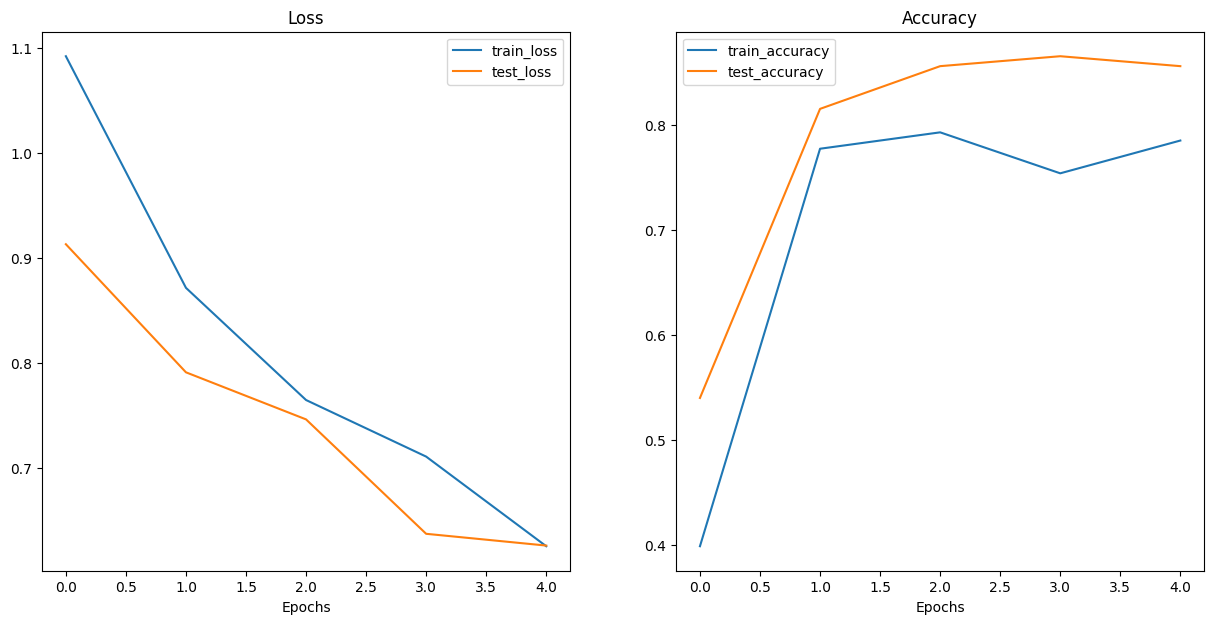

In [ ]:
plot_loss_curves(results)

## 6. Make predictions on images from the test set

In [ ]:
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int]=(224, 224),
                        transform: torchvision.transforms=None,
                        device: torch.device=device):
  # Open image
  img = Image.open(image_path)

  # Create transformation for image, if not exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(size=image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    ### Predict on image ###

    # move model to target device
    model.to(device)

    # Turn on eval mode
    model.eval()
    with torch.inference_mode():
      # Transform and add an extra dimension into image for batch
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # make a prediction on image
      target_image_pred = model(transformed_image.to(device))

    # convert logits -> pred probs
    probs = torch.softmax(target_image_pred, dim=1)

    # convert pred probs -> labels
    y_pred = torch.argmax(probs, dim=1) # we can also use logits instead

    # Plot image with predicted label and probs
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[y_pred]} | Prob: {probs.max():.3f}")
    plt.axis(False);

### Validation test

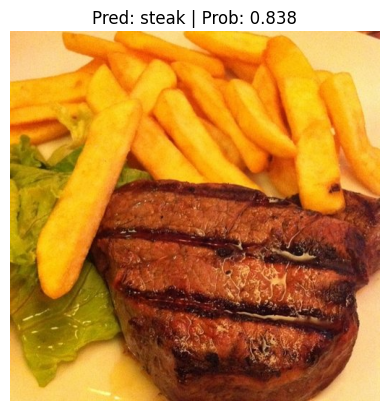

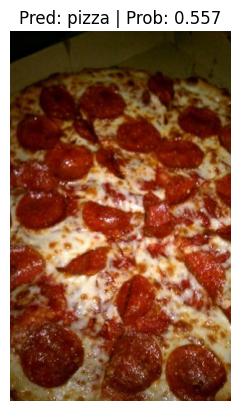

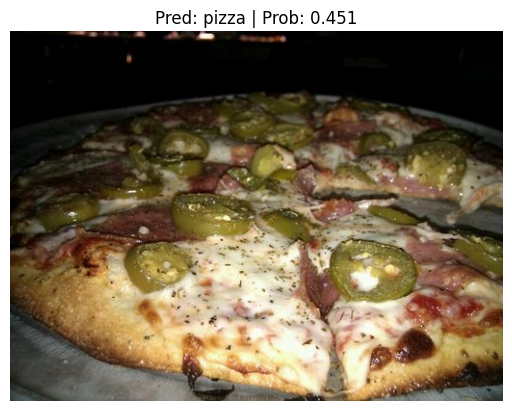

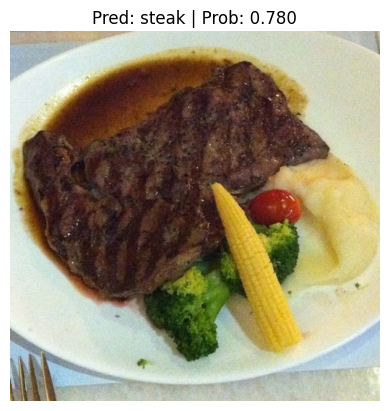

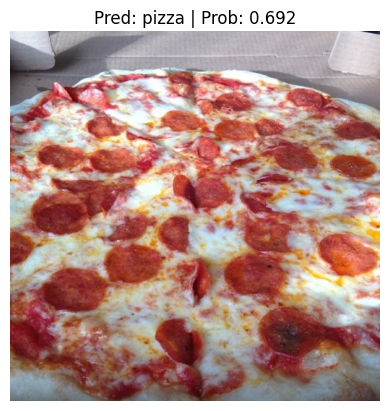

In [ ]:
# Get a random list of image paths from test set
import random

num_images_to_plot = 5
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predictions and plot images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      transform=None,
                      image_size=(224, 224))

### Make predictions on custom images

data/custom_image.jpeg exists.


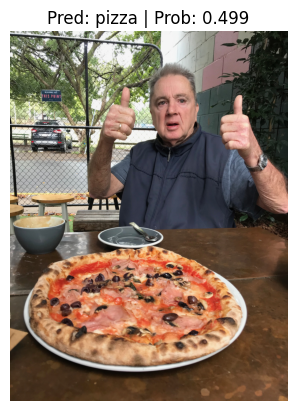

In [ ]:
import requests

custom_image_path = data_path / 'custom_image.jpeg'

# check if image exists before download
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
    print(f'Downloading {custom_image_path}...')
    f.write(request.content)
else:
  print(f"{custom_image_path} exists.")

# make prediction
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

# EXERCISE

In [ ]:
import torch
import torchvision

# List all available models
all_models = torchvision.models.list_models()
all_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [ ]:
# Get AlexNet information
alexnet_model = torchvision.models.alexnet()
alexnet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# let's try AlexNet pretrained weights
weights = torchvision.models.AlexNet_Weights.DEFAULT
weights

AlexNet_Weights.IMAGENET1K_V1

In [ ]:
preprocess = weights.transforms()
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [ ]:
# Get model summary
summary(model=alexnet_model,
        input_size=(64, 3, 256, 256),
        col_names=['input_size', 'output_size', 'num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [64, 3, 256, 256]    [64, 1000]           --                   True
├─Sequential (features)                  [64, 3, 256, 256]    [64, 256, 7, 7]      --                   True
│    └─Conv2d (0)                        [64, 3, 256, 256]    [64, 64, 63, 63]     23,296               True
│    └─ReLU (1)                          [64, 64, 63, 63]     [64, 64, 63, 63]     --                   --
│    └─MaxPool2d (2)                     [64, 64, 63, 63]     [64, 64, 31, 31]     --                   --
│    └─Conv2d (3)                        [64, 64, 31, 31]     [64, 192, 31, 31]    307,392              True
│    └─ReLU (4)                          [64, 192, 31, 31]    [64, 192, 31, 31]    --                   --
│    └─MaxPool2d (5)                     [64, 192, 31, 31]    [64, 192, 15, 15]    --                   --
│    └─Conv2d (6)     

In [ ]:
# We use the Imagenette dataset to test this model
imagenette_train_data = torchvision.datasets.Imagenette(root='data',
                                                  split='train',
                                                  size='full',
                                                  download=True,
                                                  transform=preprocess,
                                                  target_transform=None)
imagenette_test_data = torchvision.datasets.Imagenette(root='data',
                                                       split='val',
                                                       size='full',
                                                       download=True,
                                                       transform=preprocess,
                                                       target_transform=None)

imagenette_train_data, imagenette_test_data

(Dataset Imagenette
     Number of datapoints: 9469
     Root location: data
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            ),
 Dataset Imagenette
     Number of datapoints: 3925
     Root location: data
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            ))

In [ ]:
# Get class names
class_names = imagenette_train_data.classes
class_names

[('tench', 'Tinca tinca'),
 ('English springer', 'English springer spaniel'),
 ('cassette player',),
 ('chain saw', 'chainsaw'),
 ('church', 'church building'),
 ('French horn', 'horn'),
 ('garbage truck', 'dustcart'),
 ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
 ('golf ball',),
 ('parachute', 'chute')]

In [ ]:
import os

# turn data into dataloaders
train_dataloader = torch.utils.data.DataLoader(
    dataset=imagenette_train_data,
    batch_size=64,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=True
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=imagenette_test_data,
    batch_size=64,
    shuffle=False,
    num_workers=os.cpu_count(),
    pin_memory=True
)

In [ ]:
# Free all base layer in "features" section
for param in alexnet_model.features.parameters():
  param.requires_grad = False

In [ ]:
output_shape = len(class_names)
output_shape

10

(classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )

In [ ]:
# Recreate classifier's last layer to output 10 classes instead of 1000
alexnet_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=9216, out_features=4096, bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(in_features=4096, out_features=4096, bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(in_features=4096, out_features=10, bias=True)
)

In [ ]:
summary(model=alexnet_model,
        input_size=(64, 3, 256, 256),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [64, 3, 256, 256]    [64, 10]             --                   Partial
├─Sequential (features)                  [64, 3, 256, 256]    [64, 256, 7, 7]      --                   False
│    └─Conv2d (0)                        [64, 3, 256, 256]    [64, 64, 63, 63]     (23,296)             False
│    └─ReLU (1)                          [64, 64, 63, 63]     [64, 64, 63, 63]     --                   --
│    └─MaxPool2d (2)                     [64, 64, 63, 63]     [64, 64, 31, 31]     --                   --
│    └─Conv2d (3)                        [64, 64, 31, 31]     [64, 192, 31, 31]    (307,392)            False
│    └─ReLU (4)                          [64, 192, 31, 31]    [64, 192, 31, 31]    --                   --
│    └─MaxPool2d (5)                     [64, 192, 31, 31]    [64, 192, 15, 15]    --                   --
│    └─Conv2d (6

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=alexnet_model.parameters(),
                             lr=1e-4)

In [ ]:
start_time = timer()

results = engine.train(model=alexnet_model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=100,
                       device=device)

end_time = timer()
print(f'Total training time: {end_time - start_time} seconds')

Epoch: 1 | train_loss: 1.5333 | train_acc: 0.4729 | test_loss: 1.5132 | test_acc: 0.4924
Epoch: 2 | train_loss: 1.4797 | train_acc: 0.4969 | test_loss: 1.4785 | test_acc: 0.5075
Epoch: 3 | train_loss: 1.4480 | train_acc: 0.5068 | test_loss: 1.4721 | test_acc: 0.5170
Epoch: 4 | train_loss: 1.4039 | train_acc: 0.5230 | test_loss: 1.4877 | test_acc: 0.4966
Epoch: 5 | train_loss: 1.3720 | train_acc: 0.5359 | test_loss: 1.4762 | test_acc: 0.5084
Epoch: 6 | train_loss: 1.3587 | train_acc: 0.5386 | test_loss: 1.3802 | test_acc: 0.5407
Epoch: 7 | train_loss: 1.3226 | train_acc: 0.5557 | test_loss: 1.3769 | test_acc: 0.5402
Epoch: 8 | train_loss: 1.3006 | train_acc: 0.5612 | test_loss: 1.3621 | test_acc: 0.5528
Epoch: 9 | train_loss: 1.2729 | train_acc: 0.5771 | test_loss: 1.3243 | test_acc: 0.5576
Epoch: 10 | train_loss: 1.2498 | train_acc: 0.5769 | test_loss: 1.3428 | test_acc: 0.5576
Epoch: 11 | train_loss: 1.2300 | train_acc: 0.5857 | test_loss: 1.2982 | test_acc: 0.5742
Epoch: 12 | train_l

## Let's try ResNet152

In [ ]:
import torch
import torchvision

try:
  from torchinfo import summary
except:
  !pip -q install torchinfo
  from torchinfo import summary

In [ ]:
resnet_model = torchvision.models.resnet152()
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
weights = torchvision.models.ResNet152_Weights.DEFAULT
weights

ResNet152_Weights.IMAGENET1K_V2

In [ ]:
data_transform = weights.transforms()
data_transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
### Download Imagenette dataset (again because runtime was disconnected)
imagenette_train = torchvision.datasets.Imagenette(root='data',
                                                   split='train',
                                                   size='full',
                                                   download=True,
                                                   transform=data_transform)
imagenette_test = torchvision.datasets.Imagenette(root='data',
                                                  split='val',
                                                  size='full',
                                                  transform=data_transform)

imagenette_train, imagenette_test

(Dataset Imagenette
     Number of datapoints: 9469
     Root location: data
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[232]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            ),
 Dataset Imagenette
     Number of datapoints: 3925
     Root location: data
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[232]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            ))

In [ ]:
class_names = imagenette_train.classes
class_names

[('tench', 'Tinca tinca'),
 ('English springer', 'English springer spaniel'),
 ('cassette player',),
 ('chain saw', 'chainsaw'),
 ('church', 'church building'),
 ('French horn', 'horn'),
 ('garbage truck', 'dustcart'),
 ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
 ('golf ball',),
 ('parachute', 'chute')]

In [ ]:
import os

# convert data to dataloaders
train_dataloader = torch.utils.data.DataLoader(
    dataset=imagenette_train,
    batch_size=32,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=True
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=imagenette_test,
    batch_size=32,
    shuffle=False,
    num_workers=os.cpu_count(),
    pin_memory=True
)

In [ ]:
# get model summary
summary(model=resnet_model,
       input_size=(32, 3, 232, 232),
       col_names=['input_size', 'output_size', 'num_params', 'trainable'],
       col_width=20,
       row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 232, 232]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 232, 232]    [32, 64, 116, 116]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 116, 116]   [32, 64, 116, 116]   128                  True
├─ReLU (relu)                            [32, 64, 116, 116]   [32, 64, 116, 116]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 116, 116]   [32, 64, 58, 58]     --                   --
├─Sequential (layer1)                    [32, 64, 58, 58]     [32, 256, 58, 58]    --                   True
│    └─Bottleneck (0)                    [32, 64, 58, 58]     [32, 256, 58, 58]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 58, 58]     [32, 64, 58, 58]     4,096                True
│    │    └─BatchN

In [ ]:
# Fine tune the model
for param in resnet_model.parameters():
  param.requires_grad = False

In [ ]:
resnet_model.fc = torch.nn.Linear(in_features=2048,
                                  out_features=10)

In [ ]:
summary(model=resnet_model,
        input_size=(32, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [ ]:
# setup loss and optimzier
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet_model.parameters(),
                             lr=0.00123,
                             weight_decay=1e-4)

In [ ]:
# setup accuracy object
try:
  from torchmetrics import Accuracy
except:
  !pip -q install torchmetrics
  from torchmetrics import Accuracy

accuracy = Accuracy(task='multiclass',
                    num_classes=10)
accuracy.to(device)

MulticlassAccuracy()

### Train model ResNet152 on Imagenette dataset

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from timeit import default_timer as timer

EPOCHS = 20

# result dict
results = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

start_time = timer()

# move model to device
resnet_model.to(device)

for epoch in range(EPOCHS):

  # turn on train mode
  resnet_model.train()

  # setup train loss and acc
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(train_dataloader):
    # move data to device
    X, y = X.to(device), y.to(device)

    # forward pass
    logits = resnet_model(X)
    y_pred = logits.argmax(dim=1)

    # calculate loss
    loss = loss_fn(logits, y)

    # backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # acculmate loss and acc per batch
    train_loss += loss.item()
    train_acc += accuracy(y_pred, y).item()

  # avarage loss and acc
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  # setup test metrics
  test_loss, test_acc = 0, 0
  # Evaluate
  resnet_model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)

      logits = resnet_model(X)
      y_pred = logits.argmax(dim=1)
      loss = loss_fn(logits, y)
      test_loss += loss.item()
      test_acc += accuracy(y_pred, y).item()

  # avarage test loss and acc
  test_loss /= len(test_dataloader)
  test_acc /= len(test_dataloader)

  results['train_loss'].append(train_loss)
  results['train_acc'].append(train_acc)
  results['test_loss'].append(test_loss)
  results['test_acc'].append(test_acc)

  print(f'Epoch: {epoch+1} | '
        f'train_loss: {train_loss:.4f} | '
        f'train_acc: {train_acc:.4f} | '
        f'test_loss: {test_loss:.4f} | '
        f'test_acc: {test_acc:.4f}')

end_time = timer()
print(f'Total training time: {end_time - start_time} seconds')


Epoch: 1 | train_loss: 2.4948 | train_acc: 0.1335 | test_loss: 2.4588 | test_acc: 0.1458
Epoch: 2 | train_loss: 2.4501 | train_acc: 0.1418 | test_loss: 2.3522 | test_acc: 0.1557
Epoch: 3 | train_loss: 2.4255 | train_acc: 0.1483 | test_loss: 2.5296 | test_acc: 0.1316
Epoch: 4 | train_loss: 2.4299 | train_acc: 0.1539 | test_loss: 2.4043 | test_acc: 0.1764
Epoch: 5 | train_loss: 2.4365 | train_acc: 0.1501 | test_loss: 2.3381 | test_acc: 0.1765
Epoch: 6 | train_loss: 2.3886 | train_acc: 0.1582 | test_loss: 2.4674 | test_acc: 0.1957
Epoch: 7 | train_loss: 2.4024 | train_acc: 0.1668 | test_loss: 2.4680 | test_acc: 0.1805
Epoch: 8 | train_loss: 2.3734 | train_acc: 0.1783 | test_loss: 2.5478 | test_acc: 0.1824
Epoch: 9 | train_loss: 2.3476 | train_acc: 0.1733 | test_loss: 2.4238 | test_acc: 0.1532
Epoch: 10 | train_loss: 2.3696 | train_acc: 0.1763 | test_loss: 2.3170 | test_acc: 0.2052
Epoch: 11 | train_loss: 2.4126 | train_acc: 0.1754 | test_loss: 2.4440 | test_acc: 0.1646
Epoch: 12 | train_l